In [2]:
import sys
sys.path.append('../..')

In [3]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
import torch.nn.functional as F

/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


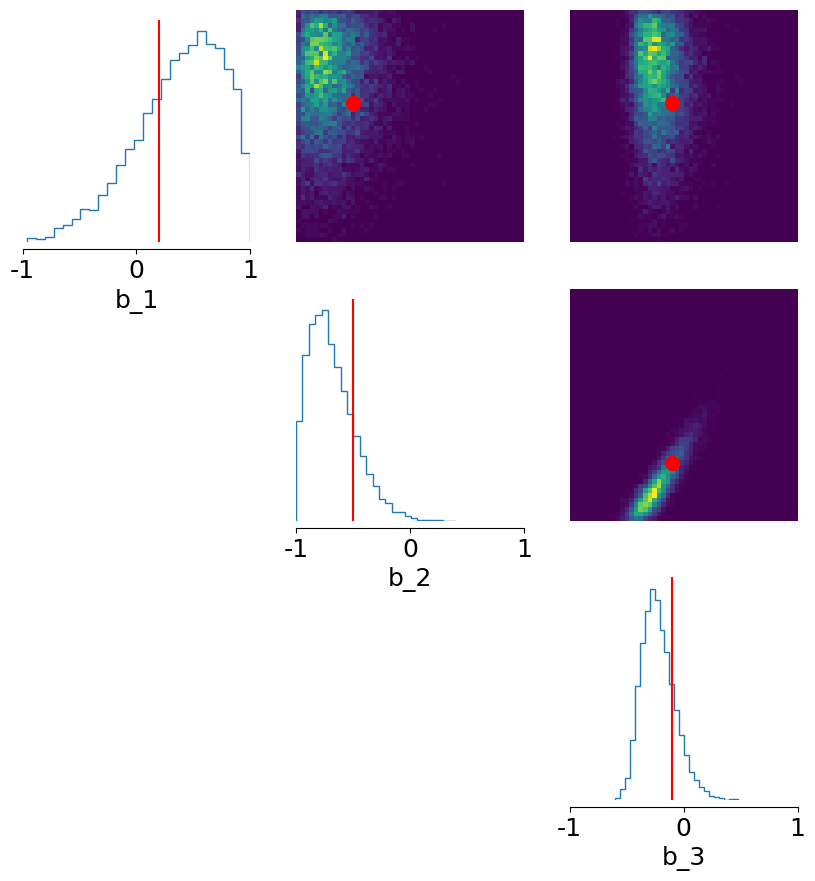

In [161]:
# new stats 1,000,000 simulations

mvgbm = np.loadtxt("../../exp_dir/mvgbm/1717142320.319533/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(mvgbm, limits=[[-1,1], [-1,1], [-1,1]], points=[np.array([0.2, -0.5, -0.1])],
                      points_colors='r', labels=["b_1", "b_2", "b_3"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

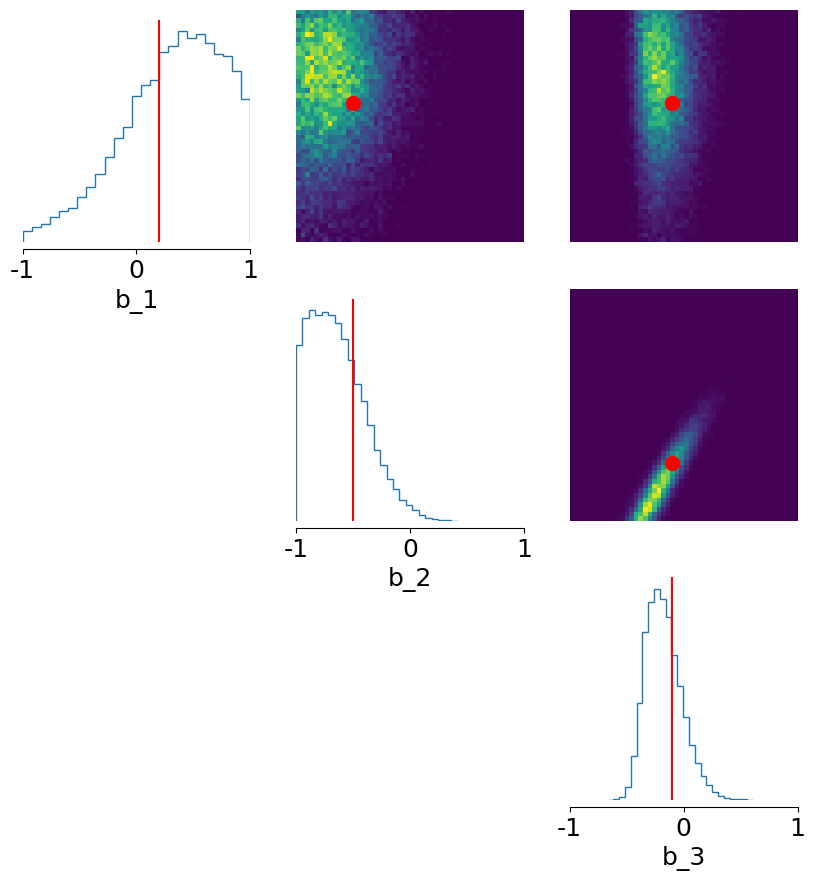

In [235]:
# new stats 100000 simulations 
# resnet

mvgbm = np.loadtxt("../../exp_dir/mvgbm/1717152235.5724897/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(mvgbm, limits=[[-1,1], [-1,1], [-1,1]], points=[np.array([0.2, -0.5, -0.1])],
                      points_colors='r', labels=["b_1", "b_2", "b_3"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

# MAP

In [205]:
from sbi4abm.utils import io

mvgbmf = io.load_task('mvgbm')

file_name = "1717096072.0776567"
with open(f"../../exp_dir/mvgbm/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [8]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

# Posterior Predictive Checks 

In [256]:
idxs = np.random.randint(mvgbm.shape[0], size=1000)

### Posterior Predictives

In [257]:
pps = []
for idx in idxs:
    data = mvgbmf[0](list(mvgbm[idx]))
    pps.append(data)

In [258]:
posterior_cum_returns = []
posterior_max_drawdown = []
posterior_volatility = []
posterior_value_at_risk = []
posterior_expected_shortfall = []
posterior_portfolio_return = []

for pp in pps:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    returns = np.diff(pp, axis=0) / pp[:-1]
    volatility = returns.std(axis=0)

    cum_returns = np.prod(1 + returns, axis=0) - 1
    value_at_risk = np.percentile(cum_returns, 100 * 0.05, axis=0)

    excess_returns = returns - 0.0 / 252
    expected_shortfall = np.mean(cum_returns[cum_returns < value_at_risk], axis=0)

    peak = np.maximum.accumulate(cum_returns, axis=0)
    drawdown = (cum_returns - peak) / peak
    max_drawdown = np.min(drawdown, axis=0)

    w = np.array([0.4, 0.3, 0.3])
    portfolio_return = np.sum(w * (1 + cum_returns))

    posterior_cum_returns.append(cum_returns)
    posterior_max_drawdown.append(max_drawdown)
    posterior_volatility.append(volatility)
    posterior_value_at_risk.append(value_at_risk)
    posterior_expected_shortfall.append(expected_shortfall)
    posterior_portfolio_return.append(portfolio_return)

### Prior Predictives

In [259]:
pps_ = []
for idx in idxs:
    data = mvgbmf[0](list(mvgbmf[1].sample().tolist()))
    pps_.append(data)

In [260]:
prior_cum_returns = []
prior_max_drawdown = []
prior_volatility = []
prior_value_at_risk = []
prior_expected_shortfall = []
prior_portfolio_return = []

for pp in pps_:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    returns = np.diff(pp, axis=0) / pp[:-1]
    volatility = returns.std(axis=0)

    cum_returns = np.prod(1 + returns, axis=0) - 1
    value_at_risk = np.percentile(cum_returns, 100 * 0.05, axis=0)

    excess_returns = returns - 0.0 / 252
    expected_shortfall = np.mean(cum_returns[cum_returns < value_at_risk], axis=0)

    peak = np.maximum.accumulate(cum_returns, axis=0)
    drawdown = (cum_returns - peak) / peak
    max_drawdown = np.min(drawdown, axis=0)

    w = np.array([0.4, 0.3, 0.3])
    portfolio_return = np.sum(w * (1 + cum_returns))

    prior_cum_returns.append(cum_returns)
    prior_max_drawdown.append(max_drawdown)
    prior_volatility.append(volatility)
    prior_value_at_risk.append(value_at_risk)
    prior_expected_shortfall.append(expected_shortfall)
    prior_portfolio_return.append(portfolio_return)

### Observation

In [261]:
obs = mvgbmf[2]
obs_returns = np.diff(obs, axis=0) / obs[:-1]
obs_volatility = obs_returns.std(axis=0)

obs_cum_returns = np.prod(1 + obs_returns, axis=0) - 1
obs_value_at_risk = np.percentile(obs_cum_returns, 100 * 0.05, axis=0)
obs_expected_shortfall = np.mean(obs_cum_returns[obs_cum_returns < obs_value_at_risk], axis=0)

peak = np.maximum.accumulate(obs_cum_returns, axis=0)
drawdown = (obs_cum_returns - peak) / peak
obs_max_drawdown = np.min(drawdown, axis=0)

w = np.array([0.4, 0.3, 0.3])
obs_portfolio_return = np.sum(w * (1 + obs_cum_returns))

In [262]:
print(len(returns))

99


In [263]:
first_elements = [arr[0] for arr in posterior_cum_returns]
print(obs_portfolio_return)

0.9345228605573208


### Plots

In [264]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

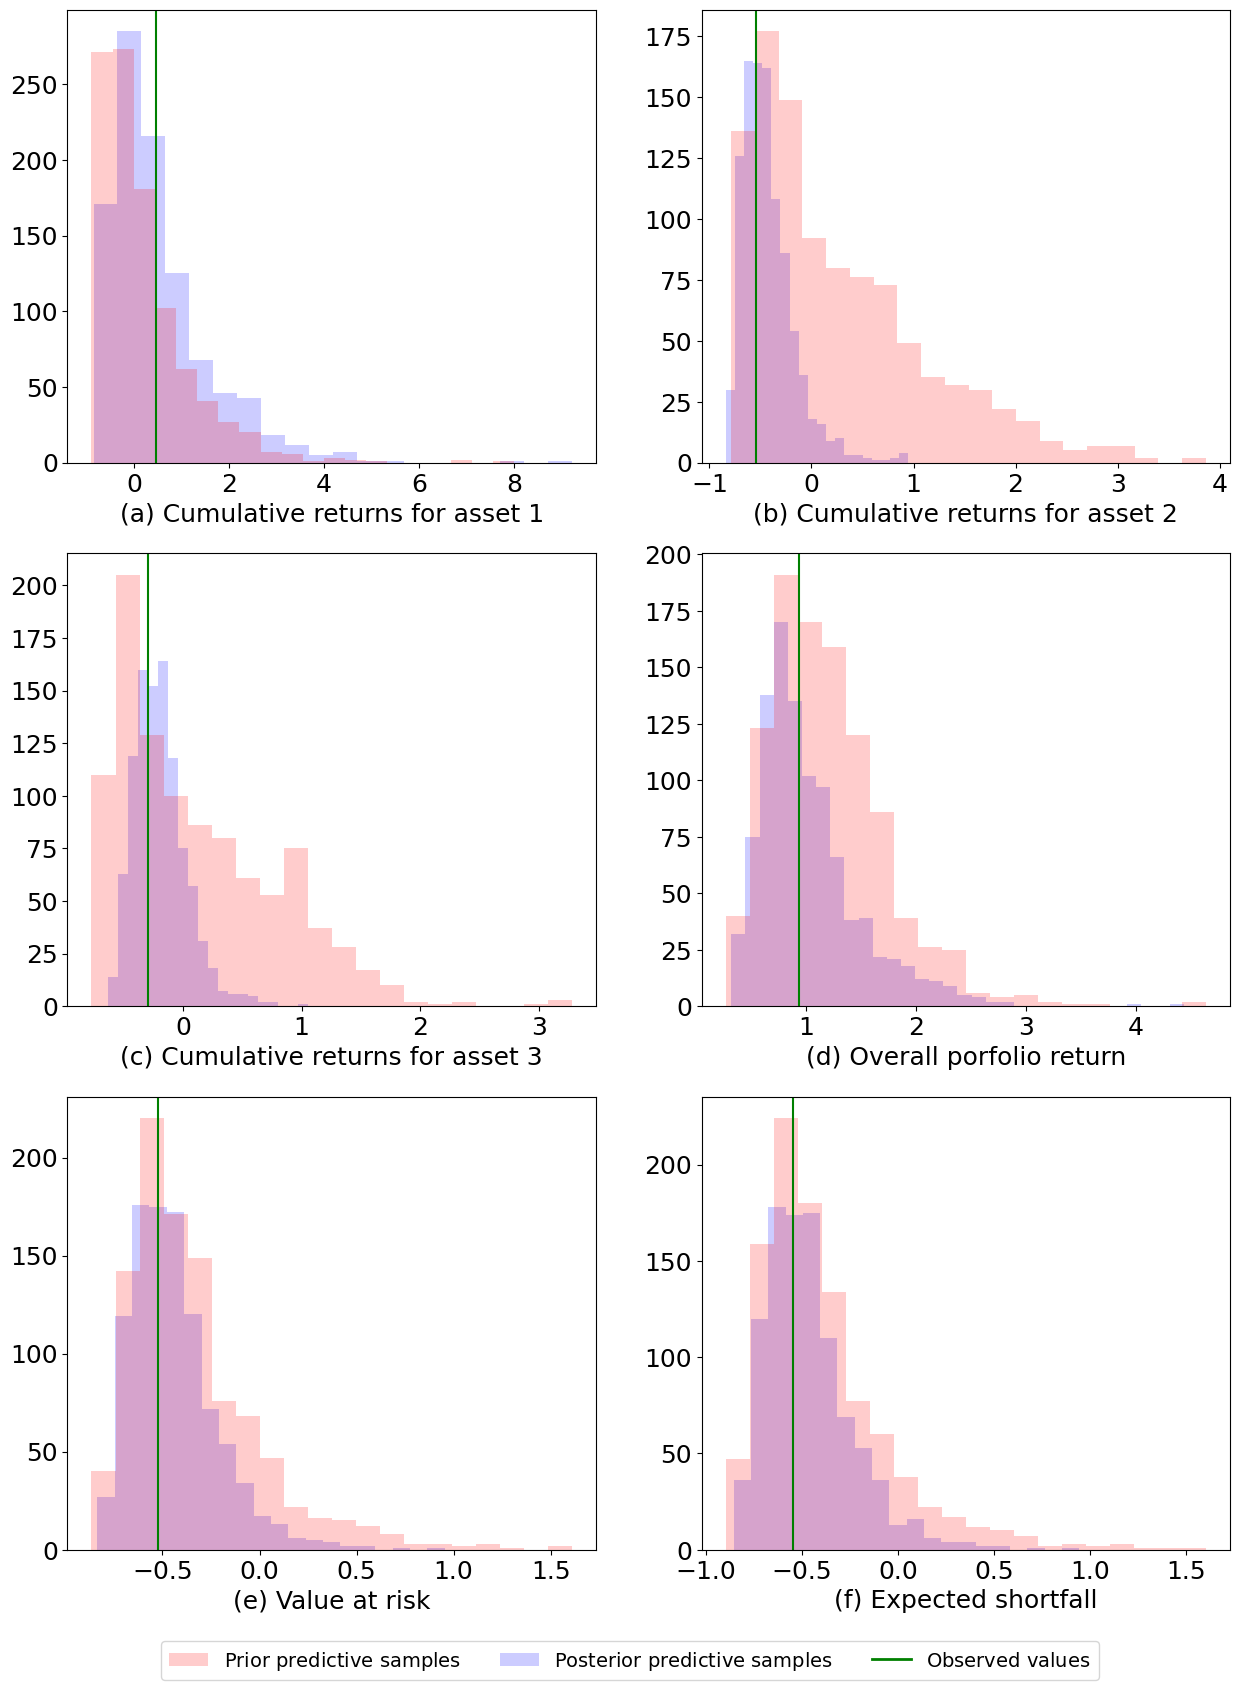

In [268]:
fig, axes = plt.subplots(3, 2, figsize=(15,20))

axes[0, 0].hist([arr[0] for arr in posterior_cum_returns], bins=20, color='b', alpha=0.2)
axes[0, 0].hist([arr[0] for arr in prior_cum_returns], bins=20, color='r', alpha=0.2)
axes[0, 0].axvline(obs_cum_returns[0], c='g')
axes[0, 0].set_xlabel(r"(a) Cumulative returns for asset 1", fontsize=18)

axes[0, 1].hist([arr[1] for arr in posterior_cum_returns], bins=20, color='b', alpha=0.2)
axes[0, 1].hist([arr[1] for arr in prior_cum_returns], bins=20, color='r', alpha=0.2)
axes[0, 1].axvline(obs_cum_returns[1], c='g')
axes[0, 1].set_xlabel(r"(b) Cumulative returns for asset 2", fontsize=18)

axes[1, 0].hist([arr[2] for arr in posterior_cum_returns], bins=20, color='b', alpha=0.2)
axes[1, 0].hist([arr[2] for arr in prior_cum_returns], bins=20, color='r', alpha=0.2)
axes[1, 0].axvline(obs_cum_returns[2], c='g')
axes[1, 0].set_xlabel(r"(c) Cumulative returns for asset 3", fontsize=18)
                             
axes[1, 1].hist(posterior_portfolio_return, bins=32, color='b', alpha=0.2)
axes[1, 1].hist(prior_portfolio_return, bins=20, color='r', alpha=0.2)
axes[1, 1].axvline(obs_portfolio_return, c='g')
axes[1, 1].set_xlabel(r"(d) Overall porfolio return", fontsize=18)

# axes[1, 1].hist(posterior_max_drawdown, bins=32, color='b', alpha=0.2)
# axes[1, 1].hist(prior_max_drawdown, bins=20, color='r', alpha=0.2)
# axes[1, 1].axvline(obs_max_drawdown, c='g')
# axes[1, 1].set_xlabel(r"(d) Overall porfolio return", fontsize=18)
# # axes[1, 1].set_xlim([-150, 1])

axes[2, 0].hist(posterior_value_at_risk, bins=20, color='b', alpha=0.2)
axes[2, 0].hist(prior_value_at_risk, bins=20, color='r', alpha=0.2)
axes[2, 0].axvline(obs_value_at_risk, c='g')
axes[2, 0].set_xlabel(r"(e) Value at risk", fontsize=18)

axes[2, 1].hist(posterior_expected_shortfall, bins=20, color='b', alpha=0.2)
axes[2, 1].hist(prior_expected_shortfall, bins=20, color='r', alpha=0.2)
axes[2, 1].axvline(obs_expected_shortfall, c='g')
axes[2, 1].set_xlabel(r"(f) Expected shortfall", fontsize=18)

# axes[2, 0].hist([arr[0] for arr in posterior_volatility], bins=20, color='b', alpha=0.2)
# axes[2, 0].hist([arr[0] for arr in prior_volatility], bins=20, color='r', alpha=0.2)
# axes[2, 0].axvline(obs_volatility[0], c='g')
# axes[2, 0].set_xlabel(r"(a) Volatility for asset 1", fontsize=18)

# axes[2, 1].hist([arr[1] for arr in posterior_volatility], bins=20, color='b', alpha=0.2)
# axes[2, 1].hist([arr[1] for arr in prior_volatility], bins=20, color='r', alpha=0.2)
# axes[2, 1].axvline(obs_cum_returns[1], c='g')
# axes[2, 1].set_xlabel(r"(b) Volatility for asset 2", fontsize=18)

# axes[3, 0].hist([arr[2] for arr in posterior_volatility], bins=20, color='b', alpha=0.2)
# axes[3, 0].hist([arr[2] for arr in prior_volatility], bins=20, color='r', alpha=0.2)
# axes[3, 0].axvline(obs_cum_returns[2], c='g')
# axes[3, 0].set_xlabel(r"(c) Volatility for asset 3", fontsize=18)

plt.subplots_adjust(hspace = 0.2)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0.04), ncol=3, fontsize=14)


# MAP

In [35]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()